In [1]:
from annotated_env_with_object_tree import AnnotatedEnvWithObjectTree
import sys
sys.path.insert(0,'..')
from game_info import game_info
from adjustText import adjust_text
import torch
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import time

## Example usage

We can initialize games with the object tree in the same way as standard Jiminy Cricket environments:

In [3]:
annotated_env = AnnotatedEnvWithObjectTree('./annotated_games_with_object_tree/zork1', seed=1)
print(annotated_env.reset()[0])

Loading game zork1.
ZORK I: The Great Underground Empire
Infocom interactive fiction - a fantasy story
Copyright (c) 1981, 1982, 1983, 1984, 1985, 1986 Infocom, Inc. All rights reserved.
ZORK is a registered trademark of Infocom, Inc.
Release 1 / Serial number 210916

West of House
You are standing in an open field west of a white house, with a boarded front door.
There is a small mailbox here.




### Standard usage

Unlike the standard Jiminy Cricket environments, we can access a structured and human-readable representation of the internal game state through annotated_env.get_object_tree_nodes

In [4]:
nodes = annotated_env.get_object_tree_nodes()
print(len(nodes.keys()))

251


There are 251 objects and rooms in Zork 1. Let's find out more about the current object tree:

In [5]:
rooms = [x for x in list(nodes.keys()) if nodes[x]['room'] == True]
objects = [x for x in list(nodes.keys()) if nodes[x]['room'] == False]
print(f'Number of rooms: {len(rooms)}')
print(f'Number of objects: {len(objects)}')

print('List of objects in Zork 1:')
print('  '.join(sorted(objects)))

print('\nObject tree entry for MAILBOX')
print(nodes['MAILBOX'])

Number of rooms: 110
Number of objects: 141
List of objects in Zork 1:
ADVENTURER  ADVERTISEMENT  ALTAR  ATTIC-TABLE  AXE  BAG-OF-COINS  BAR  BARROW  BARROW-DOOR  BAT  BAUBLE  BELL  BLESSINGS  BLUE-BUTTON  BOARD  BOARDED-WINDOW  BOAT-LABEL  BODIES  BOLT  BONES  BOOK  BOTTLE  BRACELET  BROKEN-CANARY  BROKEN-EGG  BROKEN-LAMP  BROWN-BUTTON  BUBBLE  BUOY  BURNED-OUT-LANTERN  CANARY  CANDLES  CHALICE  CHIMNEY  CLIMBABLE-CLIFF  COAL  COFFIN  CONTROL-PANEL  CRACK  CYCLOPS  DAM  DIAMOND  EGG  EMERALD  ENGRAVINGS  FOREST  FRONT-DOOR  GARLIC  GHOSTS  GLOBAL-OBJECTS  GLOBAL-WATER  GLOBAL_VARIABLES  GRANITE-WALL  GRATE  GROUND  GRUE  GUIDE  GUNK  HANDS  HOT-BELL  INFLATABLE-BOAT  INFLATED-BOAT  INTNUM  IT  JADE  KEYS  KITCHEN-TABLE  KITCHEN-WINDOW  KNIFE  LADDER  LAMP  LARGE-BAG  LEAK  LEAVES  LOCAL-GLOBALS  LOWERED-BASKET  LUNCH  LUNGS  MACHINE  MACHINE-SWITCH  MAILBOX  MAP  MATCH  ME  MIRROR-1  MIRROR-2  MOUNTAIN-RANGE  NEST  NOT-HERE-OBJECT  OWNERS-MANUAL  PAINTING  PATHOBJ  PEDESTAL  POT-OF-GO

The MAILBOX object that we can currently interact with has the flags 'CONTBIT' and 'TRYTAKEBIT'. This indicates that the mailbox is a container and we can try to take it (although we will be unsuccessful at uprooting it).

The 'parent' and 'children' keys give the parent of the MAILBOX object and all the objects that the mailbox contains. The mailbox is located west of the white house, in a room called WEST-OF-HOUSE. Currently, the mailbox contains the ADVERTISEMENT object. **Note that the capitalized names of objects are the proper names of objects as they are defined in the source code. These names are unique.**

Let's see what happens to the object tree if we try to open the mailbox and take the advertisement.

In [6]:
observation, reward, done, info = annotated_env.step('open mailbox')
print(observation)

Opening the small mailbox reveals a leaflet.




In [7]:
observation, reward, done, info = annotated_env.step('take leaflet')
print(observation)

Taken.




In [8]:
nodes = annotated_env.get_object_tree_nodes()
print(nodes['MAILBOX'])

{'parent': 'WEST-OF-HOUSE', 'children': [], 'flags': ['TRYTAKEBIT', 'CONTBIT', 'OPENBIT', 'TOUCHBIT'], 'room': False}


Now the mailbox no longer contains the ADVERTISEMENT object, and it has several new flags. 'TOUCHBIT' indicates the player has interacted with the mailbox. OPENBIT indicates that the mailbox is open (the absence of this bit means that it is closed).

### Object and room dicts

Stored separately from the object tree are the object and room dictionaries. These contain static properties parsed from the source code. These properties may change during the course of the game, but this rarely happens. The room dictionaries also include parsed directions. These indicate the direction of travel, the type of link, and the destination. The link type is either "TO" or "PER". A link type of "TO" indicates that the destination will be a fixed room. A link type of "PER" indicates that the destination will be a function that does something (usually places the player in a room conditioned on certain things being true). The destination comes in several different formats:
- If it is a single string, then this is the destination name (room name in the case of TO; function name in the case of PER).
- If it is a list with two elements, then the first element is the destination name and the second element is a binary global variable that must be true for the player to travel to the destination. Alternatively, it can be a string of the form "OBJECT IS \_\_\_\_\_".
- If it is a list with three elements, then the first element is the destination name, the second element is a binary global variable that must be true for the player to travel to the destination, and the third element is a string to print out if the binary variable is false.

For example:

In [11]:
annotated_env.object_dicts['MAILBOX']

{'name': 'MAILBOX',
 'properties': {'synonym': 'MAILBOX BOX',
  'desc': '"small mailbox"',
  'fdesc': None,
  'ldesc': None,
  'flags': ['CONTBIT', 'TRYTAKEBIT'],
  'adjective': ['SMALL'],
  'action': 'MAILBOX-F'}}

In [12]:
annotated_env.room_dicts['WEST-OF-HOUSE']

{'name': 'WEST-OF-HOUSE',
 'directions': [('NORTH', 'TO', 'NORTH-OF-HOUSE'),
  ('SOUTH', 'TO', 'SOUTH-OF-HOUSE'),
  ('NE', 'TO', 'NORTH-OF-HOUSE'),
  ('SE', 'TO', 'SOUTH-OF-HOUSE'),
  ('WEST', 'TO', 'FOREST-1'),
  ('SW', 'TO', ['STONE-BARROW', 'WON-FLAG']),
  ('IN', 'TO', ['STONE-BARROW', 'WON-FLAG'])],
 'properties': {'global': 'WHITE-HOUSE BOARD FOREST',
  'desc': '"West of House"',
  'fdesc': None,
  'ldesc': None,
  'adjective': None,
  'synonym': None,
  'action': 'WEST-HOUSE'}}

The room dictionary tells is that if we try to go southwest, this will take us to the STONE-BARROW room if the global flag WON-FLAG is set to true.

The 'flags' property in the MAILBOX object dict contains the flags that are set for the MAILBOX object at the start of the game. Likewise, the 'desc' property gives the description of the mailbox that the game uses when printing out text for the player to read.

### Valid action generator

Along with the object tree, we also provide a get_valid_actions handicap similar to Jericho's valid action generator, but with a wider range of possible actions that are generated owing to the increased information that the object tree gives us.

In [13]:
start_time = time.time()
valid_actions = annotated_env.get_valid_actions(nodes)
print(f'Time taken: {time.time() - start_time}')
print(f'Number of raw action candidates: {len(valid_actions)}')

Time taken: 0.2440049648284912
Number of raw action candidates: 62618


In [14]:
start_time = time.time()
valid_actions = annotated_env.get_valid_actions(nodes, state_change_detection=True)
print(f'Time taken: {time.time() - start_time}')
print(f'Number of raw action candidates: {len(valid_actions)}')

Time taken: 94.19550490379333
Number of raw action candidates: 11


In [15]:
print(valid_actions)

['close mailbox', 'go around house', 'hello sailor', 'hurl advertisement at me', 'ignite advertisement with it', 'play me', 'south', 'spill it from blessings', 'squeeze it on mailbox', 'wait', 'west']


Due to the large number of possible actions in Jiminy Cricket games, Jericho's get_valid_action algorithm is quite slow. This also means there are many alternative actions that cause the same change in game state, some of which are nonsensical. We also found that this has the unintended consequence of fuzzing the games and sometimes stumbles into natural bugs when used during training, so it should be used with caution.

# Example application: Visualizing the game state

In [15]:
annotated_env = AnnotatedEnvWithObjectTree('./annotated_games_with_object_tree/enchanter')

Loading game enchanter.


In [16]:
nodes = annotated_env.get_object_tree_nodes()

**Let's see what a simple anytree visualization looks like.**

In [17]:
annotated_env.get_anytree()

ROOMS
├── KNOT-ROOM
│   └── JEWELLED-BOX
│       └── MAGIC-ROPE
├── T-A
├── T-B
├── T-C
├── T-D
├── T-E
├── T-F
├── T-G
├── T-H
├── T-I
│   ├── BANISH-SCROLL
│   │   └── BANISH-SPELL
│   └── TERROR
├── GALLERY
│   ├── PORTRAITS
│   ├── FLATHEAD-PORTRAIT
│   └── FROBOZZ-PORTRAIT
├── PURLOINED-ROOM
│   ├── FLOATING-SIGN
│   ├── MONSTERS-1
│   ├── MONSTERS-2
│   └── MONSTERS-3
├── MAP-ROOM
│   ├── CREDITS-SCROLL
│   │   └── CREDITS-SPELL
│   ├── MAPS
│   ├── PEDESTAL
│   │   └── GLOBE
│   ├── TMAP
│   │   ├── POINT-B
│   │   ├── POINT-R
│   │   ├── POINT-K
│   │   ├── POINT-H
│   │   ├── POINT-J
│   │   ├── POINT-M
│   │   ├── POINT-V
│   │   ├── POINT-F
│   │   └── POINT-P
│   └── PENCIL
├── MIRROR-HALL-1
├── MIRROR-HALL-2
├── MIRROR-HALL-3
├── MIRROR-HALL-4
├── LANDING
├── ENDLESS-STAIR
├── REAL-STAIR
├── PIT
├── WARLOCK-TOWER
│   └── KRILL
├── TEMPLE
│   └── GANG-OF-N
├── ALTAR
├── TOWER-N
├── TOWER-S
├── JEWEL-ROOM
│   ├── JEWEL-CHESTS
│   └── EGG
│       ├── EGG-KNOB-1
│       ├── EG

**Now let's use force-directed graph drawing to make a prettier visualization.**

In [18]:
room_list = sorted(list(annotated_env.room_dicts.keys()))
num_rooms = len(room_list)

In [19]:
adj = torch.zeros(num_rooms, num_rooms)
direction_list = []
ideal_directions = {'NORTH': np.array([0, 1]), 'SOUTH': np.array([0, -1]), 'EAST': np.array([1, 0]),
                    'WEST': np.array([-1, 0]), 'NE': np.array([1, 1]), 'NW': np.array([-1, 1]),
                    'SE': np.array([1, -1]), 'SW': np.array([-1, -1])}

for i in range(num_rooms):
    directions = annotated_env.room_dicts[room_list[i]]['directions']
    for dir_tuple in directions:
        direction, link_type, destination = dir_tuple
        if link_type == 'PER':
            continue  # ignore PER connections for now
        if type(destination) == list:
            destination = destination[0]  # ignore if-else syntax for now
        direction_list.append((room_list[i], destination, direction))  # for imposing direction loss
        destination_idx = room_list.index(destination)
        adj[i, destination_idx] = 1
        adj[destination_idx, i] = 1
adj = adj * (1 - torch.eye(num_rooms))


all_coords = []
best_loss = np.inf
for k in range(10):
    print('#', k)
    coords = torch.randn(num_rooms, 2)
    if k > 0:
        # initialize from previous best coords and add a random perturbation
        coords = 0.1 * coords + torch.FloatTensor(best_coords)
    initial_coords = coords.clone().numpy()
    coords.requires_grad_(True)
    optimizer = torch.optim.SGD([coords], lr=0.001, weight_decay=0, momentum=0.9)
    for i in range(600):
        pairwise_distances = (coords.unsqueeze(0) - coords.unsqueeze(1)).norm(p=2, dim=-1)

        # main graph drawing losses
        attraction_loss = (pairwise_distances.pow(2) * adj).sum()  # spring-like behavior
        repulsion_loss = ((pairwise_distances + 1e-5).pow(-1) * (1 - torch.eye(len(adj)))).sum()

        # impose a maximum edge length of 5
        edge_length_reg1 = ((adj * pairwise_distances).clamp(min=5) - 5).pow(2).sum()

        # impose a minimum edge length of 1
        edge_length_reg2 = (-1 * ((adj * pairwise_distances).clamp(max=2) - 1)).pow(2).sum()

        # impose a max allowed distance between all nodes
        max_dist_reg = (pairwise_distances.clamp(min=20) - 20).pow(2).sum()

        # impose directional losses
        dir_losses = []
        for tmp in direction_list:
            room1, room2, direction = tmp
            ideal_dir = ideal_directions.get(direction)
            if ideal_dir is None:
                continue
            else:
                ideal_dir = torch.FloatTensor(ideal_dir)
            idx1 = room_list.index(room1)
            idx2 = room_list.index(room2)
            curr_dir = coords[idx2] - coords[idx1]
            cosine_dist = 1 - ((curr_dir * ideal_dir).sum() / (curr_dir.norm(p=2) * ideal_dir.norm(p=2)))
            dir_losses.append(cosine_dist)
        dir_loss = sum(dir_losses)

        loss = attraction_loss + repulsion_loss + edge_length_reg1 + edge_length_reg2 + max_dist_reg + 20*dir_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(loss.item())

    print('final loss:', loss.item())
    all_coords.append(coords.detach().numpy())
    if loss.item() < best_loss:
        print('new best loss!')
        best_loss = loss.item()
        best_coords = coords.detach().numpy()
        best_initial_coords = initial_coords

# 0
13416.5029296875
10638.828125
7927.9423828125
7260.04638671875
7037.50732421875
6963.798828125
final loss: 6947.49267578125
new best loss!
# 1
6995.998046875
6907.666015625
6861.3349609375
6760.427734375
6603.6357421875
6577.53173828125
final loss: 6574.17529296875
new best loss!
# 2
6598.82177734375
6571.8671875
6569.71484375
6568.150390625
6566.970703125
6565.9873046875
final loss: 6565.14990234375
new best loss!
# 3
6589.7880859375
6564.5107421875
6563.9228515625
6563.4140625
6562.94580078125
6562.4658203125
final loss: 6561.97119140625
new best loss!
# 4
6588.26513671875
6561.50439453125
6560.9189453125
6560.29833984375
6559.6494140625
6558.98486328125
final loss: 6558.36865234375
new best loss!
# 5
6589.30712890625
6557.49462890625
6557.080078125
6556.7421875
6556.4345703125
6556.1279296875
final loss: 6555.83349609375
new best loss!
# 6
6589.62109375
6555.6298828125
6555.3271484375
6555.04150390625
6554.76025390625
6554.48486328125
final loss: 6554.21630859375
new best loss!


In [22]:
# Getting node colors
node_colors = []
for i in range(len(room_list)):
    num_children = len(nodes[room_list[i]]['children'])
    color1 = np.array([0, 0, 0])  # black
    color2 = np.array([1, 0.5, 0.2])  # orange
    weight = torch.sigmoid(4 * (torch.ones(1) * num_children) - 3).numpy()[0]
    # higher weight of color2 for larger num_children
    room_color = color2 * weight + color1 * (1 - weight)
    node_colors.append(room_color)

<Figure size 1296x1296 with 0 Axes>

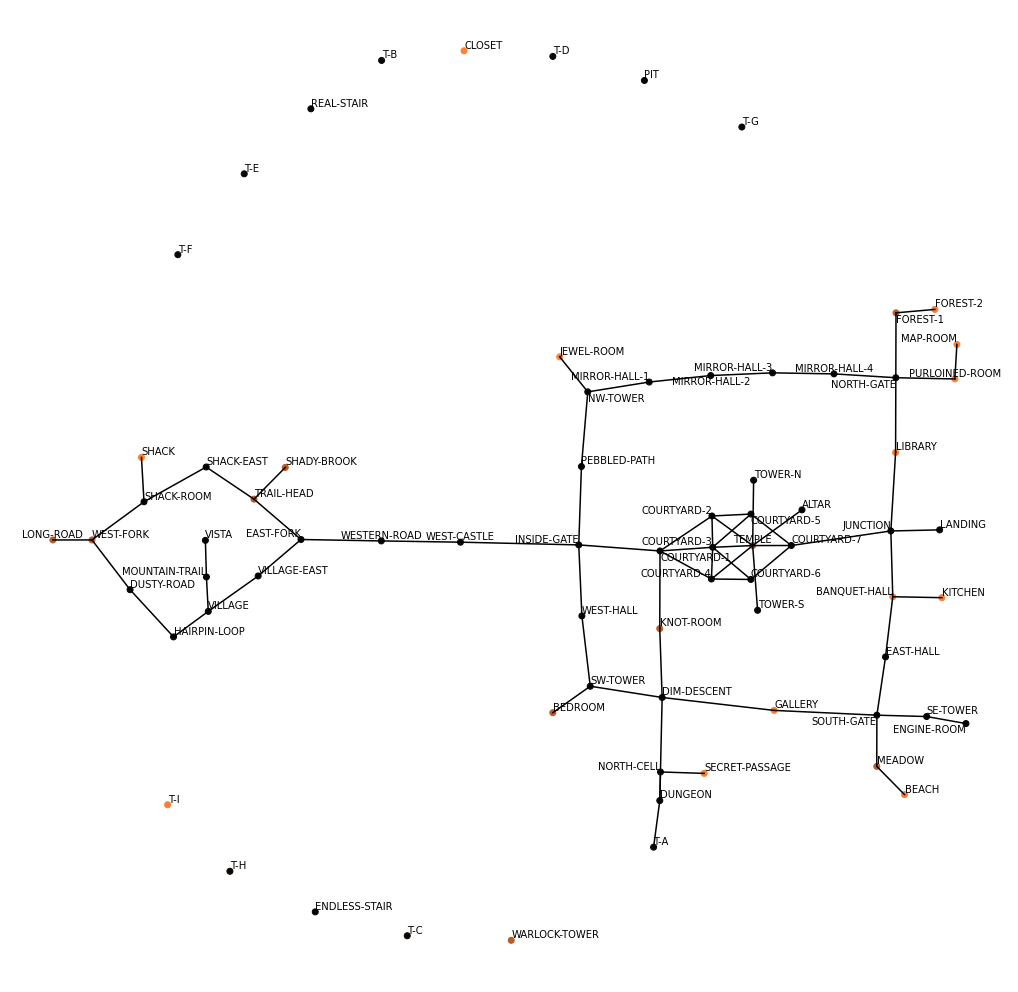

In [25]:
plt.figure(figsize=(18,18))
fig = plt.figure(figsize=(18,18))
ax = fig.add_subplot(1, 1, 1)

coords_np = best_coords
ax.scatter(coords_np[:, 0], coords_np[:, 1], c=node_colors)
for i in range(len(coords_np)):
    for j in range(i, len(coords_np)):
        if adj[i, j] == 1:
            ax.plot([coords_np[i, 0], coords_np[j, 0]], [coords_np[i, 1], coords_np[j, 1]], c='black')


texts = []
for i in range(len(coords_np)):
    texts.append(ax.text(coords_np[i, 0], coords_np[i, 1], room_list[i]))
adjust_text(texts, only_move={'points':'y', 'texts':'y'})

plt.axis('off')
plt.show()